<a href="https://colab.research.google.com/github/LonnyCox55/MSDS692_ParasiticInfectionCNN/blob/main/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lonny Cox-Lauf
#MSDS692: Data Science Practicum I
#CNN to Classify Parasitic Infection Type using Microscopic Images

This is the main Python notebook file that will clean the image data files, train, and evaluate the CNN models to classify types of parasitic eggs through microscopy.

In [1]:
# Import all necessary TensorFlow libraries
from tensorflow.keras import backend as K
from tensorflow.keras import backend
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Library for data augmentation
from tensorflow.keras.preprocessing import image

In [2]:
# Import all other necessary libraries for the project
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display # Library to help view images
from PIL import Image # Library to help view images
import os, shutil # Library for navigating files
from google.colab import drive # Library to mount google drives
import glob

In [3]:
# TO DO: Import all the CNN model instantiation functions


In [4]:
# Seed the random number generator for consistency
np.random.seed(55)

In [5]:
# Mount the Google Drive to access the image data .zip files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Un-zip all the training and testing image data files into Google Drive
!unzip gdrive/MyDrive/MSDS692_Practicum_I/data/Chula-ParasiteEgg-11.zip > /dev/null
#!unzip gdrive/MyDrive/MSDS692_Practicum_I/data/Chula-ParasiteEgg-11_test.zip > /dev/null TO DO: should I use this test data? It's unlabeled...

In [7]:
# Specify the base directory where all the images are located
baseDir = '/content/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data'

In [8]:
# Iterate through all 11 classifications of parasitic eggs
for eggClass in ("Hymenolepis*nana*", "Ascaris*lumbricoides*", "Enterobius*vermicularis*", "Capillaria*philippinensis*", "Hymenolepis*diminuta*", "Paragonimus*spp*", "Trichuris*trichiura*", "Fasciolopsis*buski*", "Opisthorchis*viverrine*", "Taenia*spp*", "Hookworm*"):
  eggFiles = glob.glob(eggClass, root_dir = baseDir) # Find all egg image files that match the current class
  classDirName = eggClass.replace("*", "_")          # Replace * with underscore for the new subdirectory names
  np.random.shuffle(eggFiles)                        # Randomize the files
  numTestFiles = int(0.2*len(eggFiles))              # Find 20% of the number of files for the test set
  testFiles = eggFiles[-numTestFiles:]               # Create subset of the data files for the test set

  # Move each test file to the respective test set directory
  os.makedirs(baseDir + "/test/" + classDirName) # Create new test directory
  for fname in testFiles:
    shutil.move(baseDir + "/" + fname,                           # Source
                baseDir + "/test/" + classDirName + "/" + fname) # Destination

  numValFiles = int(0.16*len(eggFiles))                          # Find 20% of the remaining (training set) files for the validation set
  valFiles = eggFiles[-(numTestFiles+numValFiles):-numTestFiles] # Create subset of the data files for the validation set

  # Move each validation file to the respective validation set directory
  os.makedirs(baseDir + "/val/" + classDirName) # Create new validation directory
  for fname in valFiles:
    shutil.move(baseDir + "/" + fname,                           # Source
                baseDir + "/val/" + classDirName + "/" + fname)  # Destination

  # Create subset of the data files for the training set
  numTrainFiles = len(eggFiles) - numTestFiles - numValFiles
  trainFiles = eggFiles[:numTrainFiles]

  # Move each training file to the respective training set directory
  os.makedirs(baseDir + "/train/" + classDirName) # Create new train directory
  for fname in trainFiles:
    shutil.move(baseDir + "/" + fname,                            # Source
                baseDir + "/train/" + classDirName + "/" + fname) # Destination

In [9]:
# Verify the new parasitic egg class subdirectories contain the correct split of data image files
# (using Hymenolepis nana as an example)
print("Number of training images: ", len(os.listdir(baseDir + "/train/Hymenolepis_nana_")))
print("Number of validation images: ", len(os.listdir(baseDir + "/val/Hymenolepis_nana_")))
print("Number of test images: ", len(os.listdir(baseDir + "/test/Hymenolepis_nana_")))

Number of training images:  640
Number of validation images:  160
Number of test images:  200


In [10]:
# Specify the training, validation, and test directories
trainDir = os.path.join(baseDir, 'train')
valDir = os.path.join(baseDir, 'val')
testDir = os.path.join(baseDir, 'test')

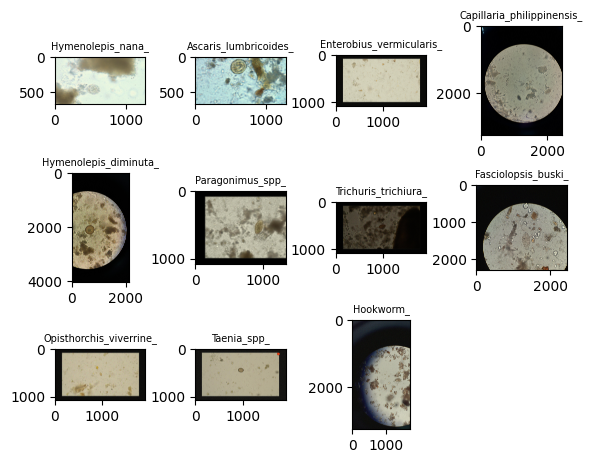

In [15]:
# Plot one of each type of parasitic egg classification from training set
i = 1
for category in ("Hymenolepis_nana_", "Ascaris_lumbricoides_", "Enterobius_vermicularis_", "Capillaria_philippinensis_", "Hymenolepis_diminuta_", "Paragonimus_spp_", "Trichuris_trichiura_", "Fasciolopsis_buski_", "Opisthorchis_viverrine_", "Taenia_spp_", "Hookworm_"):
  fullPath = os.path.join(trainDir, category)
  img = image.load_img(os.path.join(fullPath, os.listdir(fullPath)[1]))
  plt.subplot(3, 4, i)
  imgplot = plt.imshow(img)
  plt.title(category, fontsize=7)
  i += 1
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, hspace=0.35, wspace=0.55)
plt.show()

In [16]:
# Create image data generator for test data
testDatagen = ImageDataGenerator(rescale=1./255) # Just normalize pixels for test data, no augmentation

# Create image data generator for training data using Keras data augmentation techniques
trainDatagen = ImageDataGenerator(
    rescale=1./255,         # Normalize the pixel data so values are between 0 and 1 instead of 0 and 255
    rotation_range=20,      # Rotate the images randomly up to 20 degrees
    width_shift_range=0.1,  # Shift the image horizontally up to 10%
    height_shift_range=0.1, # Shift the image vertically up to 10%
    shear_range=0.1,        # Shear image up to 10%
    zoom_range=0.1,         # Zoom in on image up to 10%
    horizontal_flip=True,   # Flip image horizontally
    vertical_flip=True,     # Flip image vertically
    fill_mode='nearest')    # How to fill missing pixels after a augmentaion operation